In [1]:
import pickle
import os
from copy import copy

import pandas as pd
import numpy as np
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn
from sklearn.neighbors import KDTree

In [2]:
import pickle
import time
from IPython.display import clear_output
import sys
import os
import copy

import pandas as pd
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

from astropy.table import Table
from sklearn.preprocessing import StandardScaler

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [4]:
np.random.seed(2)
torch.manual_seed(2)

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        if self.X.shape[0] != self.y.shape[0]:
            raise ValueError
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
class MLP_GMM(nn.Module):
    def __init__(self, sizes, p):
        super().__init__()
        self.sizes = sizes
        layers = []
        for i in range(1, len(sizes)-1):
            if i > 1:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(p))
            layers.append(nn.Linear(self.sizes[i-1], self.sizes[i], bias=False))
            layers.append(nn.BatchNorm1d(self.sizes[i]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p))
        self.layers = nn.Sequential(*layers)
        self.layers.apply(self.init_weights)
        self.pi = nn.Linear(self.sizes[-2], self.sizes[-1])
        self.init_weights(self.pi)
        # self.softmax = nn.Softmax(dim=1)
        self.mu = nn.Linear(self.sizes[-2], self.sizes[-1])
        self.init_weights(self.mu)
        self.sigma = nn.Linear(self.sizes[-2], self.sizes[-1])
        self.init_weights(self.sigma)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
        self.n_gauss = self.sizes[-1]
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                          
    def forward(self, x, train_m):
        self.train(train_m)
        x = self.layers(x)
        pi, mu, sigma = nn.functional.gumbel_softmax(self.pi(x), tau=1, dim=-1) + 1e-10, self.relu(self.mu(x)), self.elu(self.sigma(x)) + 1 + 1e-10
        return pi, mu, sigma
    
    def run_epoch(self, dataloader, optimizer=None, scheduler=None, loss_f=None):
        train_m = (optimizer is not None) and (loss_f is not None)
        true, pi, mu, sigma = [], [], [], []
        for X, y in dataloader:
            if train_m:
                optimizer.zero_grad()
            batch_pi, batch_mu, batch_sigma = self(X, train_m)
            # print(y.size(), batch_mu.size(), train_m)
            if train_m:
                loss = loss_f(y, batch_pi, batch_mu, batch_sigma)
                loss.backward()
                optimizer.step()
            true.append(y.cpu().detach().numpy())
            pi.append(batch_pi.cpu().detach().numpy())
            mu.append(batch_mu.cpu().detach().numpy())
            sigma.append(batch_sigma.cpu().detach().numpy())
        if train_m:
            scheduler.step()
        true = np.concatenate(true)
        pi = np.vstack(pi)
        mu = np.vstack(mu)
        sigma = np.vstack(sigma)
        return true, pi, mu, sigma
    
    @classmethod
    def get_dataloader(cls, X, y, batch_size=2**13, shuffle=True):
        order = np.arange(X.shape[0], dtype=int)
        if shuffle:
            np.random.shuffle(order)
        dataset = SimpleDataset(X[order], y[order])
        dataloader = DataLoader(dataset, batch_size, shuffle=False)
        return dataloader

In [8]:
class HZ_dataloader:
    def __init__(self, X, y, z_thr, batch_size=2**13, shuffle=False, high_z_mult=1, device=torch.device('cpu')):
        self.device = device
        self.X = X
        self.y = y
        self.z_thr = z_thr
        self.high_z_mult = high_z_mult
        self.low_z_idx = torch.arange(len(self.y)).to(self.device)[self.y < self.z_thr]
        self.high_z_idx = torch.arange(len(self.y)).to(self.device)[self.y >= self.z_thr]
        self.high_z_idx = torch.concatenate([self.high_z_idx] * self.high_z_mult)
        self.batch_size = batch_size
        self.low_z_frac = len(self.low_z_idx) / (len(self.low_z_idx) + len(self.high_z_idx))
        self.low_z_batch_size = int(self.batch_size * self.low_z_frac)
        self.high_z_batch_size = self.batch_size - self.low_z_batch_size
        self.shuffle = shuffle
        
        self.low_z_idx_idx = np.arange(len(self.low_z_idx))
        self.high_z_idx_idx = np.arange(len(self.high_z_idx))
        if self.shuffle:
            np.random.shuffle(self.low_z_idx_idx)
            np.random.shuffle(self.high_z_idx_idx)
        self.low_z_idx_idx = torch.tensor(self.low_z_idx_idx, device=self.device)
        self.high_z_idx_idx = torch.tensor(self.high_z_idx_idx, device=self.device)
        
    
    def __iter__(self):
        self.batch_num = 0
        return self
        
    def __next__(self):
        if self.low_z_batch_size * self.batch_num >= len(self.low_z_idx_idx) or self.high_z_batch_size * self.batch_num >= len(self.high_z_idx_idx):
            raise StopIteration
        batch_X = torch.concatenate([
            self.X[self.low_z_idx[self.low_z_idx_idx[self.low_z_batch_size * self.batch_num: self.low_z_batch_size * (self.batch_num + 1)]]],
            self.X[self.high_z_idx[self.high_z_idx_idx[self.high_z_batch_size * self.batch_num: self.high_z_batch_size * (self.batch_num + 1)]]]
        ])
        batch_y = torch.concatenate([
            self.y[self.low_z_idx[self.low_z_idx_idx[self.low_z_batch_size * self.batch_num: self.low_z_batch_size * (self.batch_num + 1)]]],
            self.y[self.high_z_idx[self.high_z_idx_idx[self.high_z_batch_size * self.batch_num: self.high_z_batch_size * (self.batch_num + 1)]]]
        ])
        self.batch_num += 1
        return batch_X, batch_y

In [9]:
class DeepEnsemble_GMM_ObjToSave:
    def __init__(self, BaseModel, base_model_args, M, device, models):
        self.BaseModel = BaseModel
        self.base_model_args = base_model_args
        self.M = M
        self.device = device
        self.models = models

class DeepEnsemble_GMM:
    def __init__(self, BaseModel, base_model_args, M, device=torch.device('cpu')):
        self.BaseModel = BaseModel
        self.base_model_args = base_model_args
        self.M = M
        self.device = device
        self.models = []
        for i in range(M):
            self.models.append(BaseModel(**base_model_args).to(self.device))
        
    def loss(self, y, pi, mu, sigma):
        if not isinstance(y, torch.Tensor):
            y, pi, mu, sigma = torch.Tensor(y), torch.Tensor(pi), torch.Tensor(mu), torch.Tensor(sigma)
        comp_prob = - torch.log(sigma) - 0.5 * np.log(2 * np.pi) - 0.5 * torch.pow((y.view(-1, 1) - mu) / sigma, 2)
        mix = torch.log(pi)
        res = torch.logsumexp(comp_prob + mix, dim=-1)
        return torch.mean(-res)
    
    def save_pickle(self, file):
        obj = DeepEnsemble_GMM_ObjToSave(self.BaseModel, self.base_model_args, self.M, self.device, self.models)
        with open(file, 'wb') as f:
            pickle.dump(obj, f)
    
    @classmethod
    def load_pickle(cls, file):
        with open(file, 'rb') as f:
            obj = pickle.load(f)
        ens = DeepEnsemble_GMM(obj.BaseModel, obj.base_model_args, obj.M, obj.device)
        ens.models = copy.deepcopy(obj.models)
        return ens
                
    def fit(
        self, X_train, y_train, X_test=None, y_test=None, 
        epochs=5, batch_size=2**13, shuffle=True, high_z_mult=1, z_thr=5,
        optimizer=torch.optim.Adam, optimizer_args={'lr': 0.0005, 'weight_decay': 0.0001}, 
        scheduler=torch.optim.lr_scheduler.ExponentialLR, scheduler_args={'gamma': 0.9},
        verbose=True, metrics=[]
    ):
        X_train_tensor = torch.tensor(X_train, device=torch.device(self.device), dtype=torch.float)
        y_train_tensor = torch.tensor(y_train, device=torch.device(self.device), dtype=torch.float)
        X_test_tensor = torch.tensor(X_test, device=torch.device(self.device), dtype=torch.float)
        y_test_tensor = torch.tensor(y_test, device=torch.device(self.device), dtype=torch.float)
        
        test_dataloader = self.BaseModel.get_dataloader(
            X_test_tensor, y_test_tensor,
            batch_size=batch_size, shuffle=shuffle
        )
        
        test_m = (X_test is not None) and (y_test is not None)
        
        optimizers = []
        schedulers = []
        for model in self.models:
            optimizers.append(optimizer(model.parameters(), **optimizer_args))
            schedulers.append(scheduler(optimizers[-1], **scheduler_args))

        train_metric_vals = {metric: [] for metric in metrics}
        train_losses = []
        if test_m:
            test_metric_vals = {metric: [] for metric in metrics}
            test_losses = []
        else:
            test_metric_vals = None
            test_losses = None
    
        for epoch in range(epochs):
            start = time.time()
            
            cur_lr = schedulers[0].get_last_lr()
            
            #TRAIN
            
            # train_dataloader = self.BaseModel.get_dataloader(
            #     X_train_tensor, y_train_tensor,
            #     batch_size=batch_size, shuffle=shuffle
            # )
            train_dataloader = HZ_dataloader(
                X_train_tensor, y_train_tensor, z_thr=z_thr,
                batch_size=batch_size, shuffle=shuffle, high_z_mult=high_z_mult, device=self.device
            )
            
            epoch_pi, epoch_mu, epoch_sigma = [], [], []
            epoch_losses = []
            for i, model in enumerate(self.models):
                epoch_true, pi, mu, sigma = model.run_epoch(train_dataloader, optimizers[i], schedulers[i], self.loss)
                epoch_pi.append(pi)
                epoch_mu.append(mu)
                epoch_sigma.append(sigma)
                epoch_losses.append(self.loss(epoch_true, pi, mu, sigma).item())
            epoch_pi = np.concatenate(epoch_pi, axis=1) / len(self.models)
            epoch_mu = np.concatenate(epoch_mu, axis=1)
            epoch_sigma = np.concatenate(epoch_sigma, axis=1)
            epoch_p = (1 / (epoch_sigma * np.sqrt(2 * np.pi))) * epoch_pi
            mode = epoch_mu[np.arange(epoch_mu.shape[0]), np.argmax(epoch_p, axis=1)]
            mu = np.sum(epoch_mu * epoch_pi, axis=1)
            sigma = np.sum(epoch_sigma * epoch_pi, axis=1) + np.sum((epoch_mu - mu.reshape(-1, 1))**2 * epoch_pi, axis=1)
            
            train_losses.append(epoch_losses)
            for metric in metrics:
                train_metric_vals[metric].append(metrics[metric](epoch_true, mode))
                
            #TEST
            if test_m:     
                epoch_pi, epoch_mu, epoch_sigma = [], [], []
                epoch_losses = []
                for i, model in enumerate(self.models):
                    epoch_true, pi, mu, sigma = model.run_epoch(test_dataloader)
                    epoch_pi.append(pi)
                    epoch_mu.append(mu)
                    epoch_sigma.append(sigma)
                    epoch_losses.append(self.loss(epoch_true, pi, mu, sigma).item())
                epoch_pi = np.concatenate(epoch_pi, axis=1) / len(self.models)
                epoch_mu = np.concatenate(epoch_mu, axis=1)
                epoch_sigma = np.concatenate(epoch_sigma, axis=1)
                epoch_p = (1 / (epoch_sigma * np.sqrt(2 * np.pi))) * epoch_pi
                mode = epoch_mu[np.arange(epoch_mu.shape[0]), np.argmax(epoch_p, axis=1)]
                mu = np.sum(epoch_mu * epoch_pi, axis=1)
                sigma = np.sum(epoch_sigma * epoch_pi, axis=1) + np.sum((epoch_mu - mu.reshape(-1, 1))**2 * epoch_pi, axis=1)

                test_losses.append(epoch_losses)
                for metric in metrics:
                    test_metric_vals[metric].append(metrics[metric](epoch_true, mode))    
                
            if verbose and epoch > 0:
                clear_output(True)
                print(f'Device: {self.device}')
                print(f'Test mode: {test_m}')
                print('=' * 40)
                print(f'EPOCH #{epoch+1}/{epochs}:')
                print(f'Learning rate: {round(cur_lr[0], 8)}')
                print('-' * 40)

                print(f'Trian losses: {[round(l, 5) for l in train_losses[-1]]}')
                print(f'AVG train loss: {round(np.mean(train_losses[-1]), 5)}')
                for metric in metrics:
                      print(f'Train {metric}: {round(train_metric_vals[metric][-1], 5)}\t', end='')
                print()
                print('-' * 40)
                
                if test_m:
                    print(f'Test losses: {[round(l, 5) for l in test_losses[-1]]}')
                    print(f'AVG test loss: {round(np.mean(test_losses[-1]), 5)}')
                    for metric in metrics:
                          print(f'Test {metric}: {round(test_metric_vals[metric][-1], 5)}\t', end='')
                    print()
                    print('-' * 40)

                print(f'Time: {round(time.time() - start, 3)}')
                print('=' * 40)

                #GRAPHICS
                fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

                colors = ['blue', 'orange', 'red', 'green', 'black', 'purple']
                DISPLAY_LAG = 30
                FIRST_IDX = max(1, epoch+1-DISPLAY_LAG)
                ticks = list(range(1, epoch+2))[FIRST_IDX:]
                
                train_losses_min = list(map(np.min, train_losses))[FIRST_IDX:]
                train_losses_mean = list(map(np.mean, train_losses))[FIRST_IDX:]
                train_losses_max = list(map(np.max, train_losses))[FIRST_IDX:]
                ax[0].plot(ticks, train_losses_min, c='b', linestyle='--')
                ax[0].plot(ticks, train_losses_mean, c='b', label='Train')
                ax[0].plot(ticks, train_losses_max, c='b', linestyle='--')
                
                if test_m:
                    test_losses_min = list(map(np.min, test_losses))[FIRST_IDX:]
                    test_losses_mean = list(map(np.mean, test_losses))[FIRST_IDX:]
                    test_losses_max = list(map(np.max, test_losses))[FIRST_IDX:]
                    ax[0].plot(ticks, test_losses_min, c='orange', linestyle='--')
                    ax[0].plot(ticks, test_losses_mean, c='orange', label='Test')
                    ax[0].plot(ticks, test_losses_max, c='orange', linestyle='--')
                
                if not test_m:
                    y_min = min(train_losses_min)
                    y_max = max(train_losses_max)
                else:
                    y_min = min(train_losses_min+test_losses_min)
                    y_max = max(train_losses_max+test_losses_max)
                y_min -= 0.3 * np.abs(y_min)
                y_max += 0.3 * np.abs(y_max)
                ax[0].set_ylim(y_min, y_max)
                ax[0].set_xticks(ticks)
                ax[0].set_xlabel('Epochs', fontsize=12)
                ax[0].set_ylabel('Loss', fontsize=12)
                ax[0].legend(loc=0, fontsize=12)
                ax[0].grid('on')
                
                for i, metric in enumerate(metrics):
                    ax[1].plot(ticks, train_metric_vals[metric][FIRST_IDX:], c=colors[i], label=f'Train {metric}')
                if test_m:
                    for i, metric in enumerate(metrics):
                        ax[1].plot(ticks, test_metric_vals[metric][FIRST_IDX:], c=colors[i], linestyle='--', label=f'Test {metric}')
                t = []
                for metric in metrics:
                    t += train_metric_vals[metric][FIRST_IDX:]
                if test_m:
                    for metric in metrics:
                        t += test_metric_vals[metric][FIRST_IDX:]
                y_min, y_max = min(t), max(t)
                y_min -= 0.3 * np.abs(y_min)
                y_max += 0.3 * np.abs(y_max)
                ax[1].set_ylim(y_min, y_max)
                ax[1].set_xticks(ticks)
                ax[1].set_xlabel('Epochs', fontsize=12)
                ax[1].set_ylabel('Metric', fontsize=12)
                ax[1].legend(loc=0, fontsize=12)
                ax[1].grid('on')
                
                plt.show()
                
        return train_metric_vals, train_losses, test_metric_vals, test_losses
    
    def predict(self, X, batch_size=2**13):
        X_tensor = torch.tensor(X, device=torch.device(self.device), dtype=torch.float)
        y_tensor = torch.tensor([0] * len(X_tensor), device=torch.device(self.device), dtype=torch.float)
        
        dataloader = self.BaseModel.get_dataloader(
            X_tensor, y_tensor,
            batch_size=batch_size, shuffle=False
        )
        
        epoch_pi, epoch_mu, epoch_sigma = [], [], []
        for i, model in enumerate(self.models):
            epoch_true, pi, mu, sigma = model.run_epoch(dataloader)
            epoch_pi.append(pi)
            epoch_mu.append(mu)
            epoch_sigma.append(sigma)
        epoch_pi = np.concatenate(epoch_pi, axis=1) / len(self.models)
        epoch_mu = np.concatenate(epoch_mu, axis=1)
        epoch_sigma = np.concatenate(epoch_sigma, axis=1)
        epoch_p = (1 / (epoch_sigma * np.sqrt(2 * np.pi))) * epoch_pi
        mode = epoch_mu[np.arange(epoch_mu.shape[0]), np.argmax(epoch_p, axis=1)]
        mu = np.sum(epoch_mu * epoch_pi, axis=1)
        sigma = np.sum(epoch_sigma * epoch_pi, axis=1) + np.sum((epoch_mu - mu.reshape(-1, 1))**2 * epoch_pi, axis=1)
        
        return epoch_pi, epoch_mu, epoch_sigma, mode, sigma

In [10]:
def sigma_nmad(true, preds):
    diff = preds - true
    m = np.median(diff)
    return 1.48 * np.median(np.abs((diff - m) / (1 + true)))

def sigma_nmad_z3(true, preds):
    mask = (true >= 3)
    true = true[mask]
    preds = preds[mask]
    diff = preds - true
    m = np.median(diff)
    return 1.48 * np.median(np.abs((diff - m) / (1 + true)))

def sigma_nmad_z4(true, preds):
    mask = (true >= 4)
    true = true[mask]
    preds = preds[mask]
    diff = preds - true
    m = np.median(diff)
    return 1.48 * np.median(np.abs((diff - m) / (1 + true)))

def sigma_nmad_z5(true, preds):
    mask = (true >= 5)
    true = true[mask]
    preds = preds[mask]
    diff = preds - true
    m = np.median(diff)
    return 1.48 * np.median(np.abs((diff - m) / (1 + true)))

def sigma_nmad_z6(true, preds):
    mask = (true >= 6)
    true = true[mask]
    preds = preds[mask]
    diff = preds - true
    m = np.median(diff)
    return 1.48 * np.median(np.abs((diff - m) / (1 + true)))

In [11]:
def out_rate(true, preds):
    diff = preds - true
    return ((np.abs(diff) / (1 + true)) > 0.15).sum() / len(true)

def out_rate_z3(true, preds):
    m = (true >= 3)
    true = true[m]
    preds = preds[m]
    diff = preds - true
    return ((np.abs(diff) / (1 + true)) > 0.15).sum() / len(true)

def out_rate_z4(true, preds):
    m = (true >= 4)
    true = true[m]
    preds = preds[m]
    diff = preds - true
    return ((np.abs(diff) / (1 + true)) > 0.15).sum() / len(true)

def out_rate_z5(true, preds):
    m = (true >= 5)
    true = true[m]
    preds = preds[m]
    diff = preds - true
    return ((np.abs(diff) / (1 + true)) > 0.15).sum() / len(true)

def out_rate_z6(true, preds):
    m = (true >= 6)
    true = true[m]
    preds = preds[m]
    diff = preds - true
    return ((np.abs(diff) / (1 + true)) > 0.15).sum() / len(true)

In [12]:
def angular_dist(x, y):
    ra_01, dec_01 = x[0], x[1]
    ra_02, dec_02 = y[0], y[1]
    ra_01 = ra_01 * np.pi / 180
    ra_02 = ra_02 * np.pi / 180
    dec_01 = dec_01 * np.pi / 180
    dec_02 = dec_02 * np.pi / 180
    return np.arccos(np.minimum(
        np.sin(dec_01) * np.sin(dec_02) +
        np.cos(dec_01) * np.cos(dec_02) * np.cos(ra_01 - ra_02),
        1
    )) * 180 / (np.pi)

def correlate(d1, d2):
    kd_tree = KDTree(d1)
    d, idx = kd_tree.query(d2, k=20)

    a = []
    for i in tqdm(range(idx.shape[0])):
        min_dist = 10000
        min_id = None
        for id_ in idx[i]:
            dist = angular_dist(d2[i], d1[id_])
            if dist < min_dist:
                min_dist = dist
                min_id = id_
        if min_dist < 2/3600:
            a.append([min_id, min_dist, i])
        else:
            a.append([min_id, min_dist, i])
    return np.array(a)

In [13]:
data_dir = 'data'
with open(f'{data_dir}/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    features_list = pickle.load(f)
models_cols = ['max19_z', 'conf19_z', 'max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z']
for s in ['pi', 'mu', 'sigma']:
    for i in range(15):
        models_cols.append(f'{s}_{str(i).zfill(2)}_35')
models_cols.append('sigma')
models_cols.append('mode')

In [14]:
t = Table.read(f'{data_dir}/dr16q_prop_Sep08_2022.fits')
print(t.colnames)
dr16q_prop = t['OBJID', 'RA', 'DEC', 'Z_DR16Q', 'Z_SYS', 'Z_SYS_ERR'].to_pandas()
dr16q_prop.rename(columns={'Z_DR16Q': 'Z'}, inplace=True)
dr16q_prop['dr16q'] = [True] * dr16q_prop.shape[0]
dr16q_prop['train20'] = [False] * dr16q_prop.shape[0]
dr16q_prop['superset'] = [False] * dr16q_prop.shape[0]
for fea in features_list:
    dr16q_prop[fea] = [None] * dr16q_prop.shape[0]
for m in models_cols:
    dr16q_prop[m] = [None] * dr16q_prop.shape[0]
dr16q_prop.sort_values(by=['RA'], inplace=True)
dr16q_prop.drop_duplicates(subset=['RA', 'DEC'], inplace=True, keep='last')
dr16q_prop.reset_index(drop=True, inplace=True)
dr16q_prop.insert(6, 'Z_SYS_DIFF', dr16q_prop['Z_SYS'] - dr16q_prop['Z'])
dr16q_prop.insert(7, 'Z_SYS_DIFF_ABS', np.abs(dr16q_prop['Z_SYS'] - dr16q_prop['Z']))
dr16q_prop.insert(9, 'dr16q_prop', (dr16q_prop['Z_SYS_DIFF_ABS'] >= 0.1))
dr16q_prop

['SDSS_NAME', 'PLATE', 'MJD', 'FIBERID', 'RA', 'DEC', 'OBJID', 'IF_BOSS_SDSS', 'Z_DR16Q', 'SOURCE_Z_DR16Q', 'Z_FIT', 'Z_SYS', 'Z_SYS_ERR', 'EBV', 'SN_MEDIAN_ALL', 'CONTI_FIT', 'CONTI_FIT_ERR', 'CONTI_STAT', 'FEII_UV', 'FEII_UV_ERR', 'FEII_UV_EW', 'FEII_UV_EW_ERR', 'FEII_OPT', 'FEII_OPT_ERR', 'FEII_OPT_EW', 'FEII_OPT_EW_ERR', 'LOGL1350', 'LOGL1350_ERR', 'LOGL1700', 'LOGL1700_ERR', 'LOGL3000', 'LOGL3000_ERR', 'LOGL5100', 'LOGL5100_ERR', 'HALPHA', 'HALPHA_BR', 'NII6585', 'SII6718', 'HBETA', 'HBETA_BR', 'HEII4687', 'HEII4687_BR', 'OIII5007', 'OIII5007C', 'CAII3934', 'OII3728', 'NEV3426', 'MGII', 'MGII_BR', 'CIII_ALL', 'CIII_BR', 'SIIII1892', 'ALIII1857', 'NIII1750', 'CIV', 'HEII1640', 'HEII1640_BR', 'SIIV_OIV', 'OI1304', 'LYA', 'NV1240', 'HALPHA_ERR', 'HALPHA_BR_ERR', 'NII6585_ERR', 'SII6718_ERR', 'HBETA_ERR', 'HBETA_BR_ERR', 'HEII4687_ERR', 'HEII4687_BR_ERR', 'OIII5007_ERR', 'OIII5007C_ERR', 'CAII3934_ERR', 'OII3728_ERR', 'NEV3426_ERR', 'MGII_ERR', 'MGII_BR_ERR', 'CIII_ALL_ERR', 'CIII_BR_

/tmp/ipykernel_2036690/144078321.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dr16q_prop[m] = [None] * dr16q_prop.shape[0]
/tmp/ipykernel_2036690/144078321.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dr16q_prop[m] = [None] * dr16q_prop.shape[0]
/tmp/ipykernel_2036690/144078321.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fra

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,b'7750-58402-0802',0.000629,35.517841,0.845435,0.846867,0.000704,0.001432,0.001432,True,False,...,None,None,None,None,None,None,None,None,None,None
1,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,None,None,None,None,None,None,None,None,None,None
2,b'7695-57654-0565',0.001526,27.732283,1.770552,1.774080,0.002622,0.003528,0.003528,True,False,...,None,None,None,None,None,None,None,None,None,None
3,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,None,None,None,None,None,None,None,None,None,None
4,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750409,b'7134-56566-0408',359.999118,28.954734,2.452000,2.451400,0.005250,-0.000600,0.000600,True,False,...,None,None,None,None,None,None,None,None,None,None
750410,b'7145-56567-0240',359.999303,34.720842,3.109000,3.112038,0.006417,0.003038,0.003038,True,False,...,None,None,None,None,None,None,None,None,None,None
750411,b'8741-57390-0060',359.999615,3.268586,1.232962,1.233783,0.000758,0.000821,0.000821,True,False,...,None,None,None,None,None,None,None,None,None,None
750412,b'7595-56957-0259',359.999759,20.721079,2.009865,2.013729,0.002790,0.003864,0.003864,True,False,...,None,None,None,None,None,None,None,None,None,None


In [15]:
d_z = dr16q_prop['Z_SYS_DIFF_ABS']
d_v = 300000 * d_z / (1 + dr16q_prop['Z_SYS'])

In [16]:
((d_z > 0.1) & (d_v > 10000)).sum()

1933

In [17]:
(d_v > 10000).sum()

1943

In [18]:
(d_z > 0.1).sum()

1941

In [19]:
ens_00_35 = DeepEnsemble_GMM.load_pickle('ens_6x400_3g_cf00_35.pkl')
ens_01_35 = DeepEnsemble_GMM.load_pickle('ens_6x400_3g_cf01_35.pkl')

In [20]:
dfs = []
for i in range(32):
    num = str(i).zfill(5)
    feas = pd.read_pickle(
        f'{data_dir}/22_DR16Q_v4-wo_20_train/part-{num}.features.gz_pkl',
        compression='gzip'
    )[['RA', 'DEC', 'Z'] + features_list]
    preds = pd.read_pickle(
        f'{data_dir}/22_DR16Q_v4-wo_20_train/part-{num}.predictions.x1a.gz_pkl',
        compression='gzip'
    )[['zoo_x1a19_z_max', 'zoo_x1a19_z_maxConf', 
       'zoo_x1a21_z_max', 'zoo_x1a21_z_maxConf', 
       'zoo_x1a22_z_max', 'zoo_x1a22_z_maxConf', 
       'zoo_x1a35_z_max', 'zoo_x1a35_z_maxConf']]
    df = feas.merge(preds, how='right', left_index=True, right_index=True)
    dfs.append(df)
dr16q = pd.concat(dfs, axis=0)
dr16q.rename(
    columns={
        'zoo_x1a19_z_max': 'max19_z', 'zoo_x1a19_z_maxConf': 'conf19_z',
        'zoo_x1a21_z_max': 'max21_z', 'zoo_x1a21_z_maxConf': 'conf21_z',
        'zoo_x1a22_z_max': 'max22_z', 'zoo_x1a22_z_maxConf': 'conf22_z',
        'zoo_x1a35_z_max': 'max35_z', 'zoo_x1a35_z_maxConf': 'conf35_z',
    }, inplace=True)
dr16q.sort_values(by=['RA'], inplace=True)
dr16q.drop_duplicates(subset=['RA', 'DEC'], inplace=True, keep='last')
dr16q.reset_index(drop=True, inplace=True)
dr16q.replace(np.nan, None, inplace=True)
dr16q

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,max19_z,conf19_z,max21_z,conf21_z,max22_z,conf22_z,max35_z,conf35_z
0,0.001415,31.057048,2.035491,22.07464,21.787479,21.562507,21.360414,20.933499,21.817585,21.363539,...,-0.116084,-0.320602,1.735292,0.307693,1.934331,0.433418,1.855865,0.346749,2.028873,0.274436
1,0.001526,27.732283,1.770552,22.330387,21.903107,21.751831,21.664443,22.048195,21.924103,21.556177,...,-0.524986,-2.353988,1.709753,0.466287,1.730614,0.691206,1.752056,0.689963,1.682694,0.613794
2,0.001535,7.064129,1.574227,22.498194,22.103252,21.854685,21.638759,21.964469,21.761538,21.574824,...,-0.070024,-0.605396,1.445,0.45677,1.701,0.37172,1.627,0.446391,1.613,0.561226
3,0.001914,9.385637,2.024146,18.76583,18.661867,18.499508,18.335921,18.15841,18.774551,18.369465,...,0.08355,0.047153,None,None,None,None,2.121,0.638553,None,None
4,0.001978,-0.451088,0.250000,21.672738,21.193839,20.508787,20.15317,19.87858,21.432634,19.721854,...,0.009057,-0.250328,0.317354,0.441683,0.306038,0.479988,0.32021,0.185194,0.3508,0.702891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306735,359.997573,-9.826069,2.439000,22.488502,21.00742,21.059175,21.065099,20.417605,19.705819,21.006593,...,-0.469388,-0.363081,2.468,0.704687,2.459247,0.745153,2.232917,0.616561,2.522,0.733557
306736,359.997675,0.144870,1.356595,20.45271,20.535363,20.30579,20.287443,20.298002,20.508662,20.289982,...,-0.191817,-0.268319,1.110535,0.417104,1.178801,0.686697,1.102664,0.727626,1.175745,0.7415
306737,359.997704,10.564075,1.284287,20.054219,19.80636,19.387776,19.168335,19.006462,19.925669,19.138338,...,0.162244,0.082854,1.4569,0.784296,1.5509,0.877846,1.457419,0.719128,1.451017,0.844344
306738,359.998520,-0.655884,1.355954,22.055338,22.506995,21.409914,21.74893,21.66175,21.947964,21.504402,...,0.314801,-0.326978,0.854488,0.214549,1.107337,0.271965,1.096616,0.451444,1.078204,0.492389


In [21]:
m = (dr16q.isna().values.sum(1) > 0)
m, m.sum()

(array([False, False, False, ..., False, False, False]), 46341)

In [22]:
X = dr16q[features_list].values[~m].astype(float)
epoch_pi_00_35, epoch_mu_00_35, epoch_sigma_00_35, mode_00_35, sigma_00_35 = ens_00_35.predict(X)
epoch_pi_01_35, epoch_mu_01_35, epoch_sigma_01_35, mode_01_35, sigma_01_35 = ens_01_35.predict(X)

In [23]:
m_s = (sigma_00_35 <= sigma_01_35)

In [24]:
epoch_pi_00_35[~m_s] = epoch_pi_01_35[~m_s]
epoch_mu_00_35[~m_s] = epoch_mu_01_35[~m_s]
epoch_sigma_00_35[~m_s] = epoch_sigma_01_35[~m_s]
mode_00_35[~m_s] = mode_01_35[~m_s]
sigma_00_35[~m_s] = sigma_01_35[~m_s]

In [25]:
for s in ['pi', 'mu', 'sigma']:
    for i in range(15):
        dr16q[f'{s}_{str(i).zfill(2)}_35'] = [None] * dr16q.shape[0]
        if s == 'pi':
            dr16q[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_pi_00_35[:, i].copy()
        if s == 'mu':
            dr16q[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_mu_00_35[:, i].copy()
        if s == 'sigma':
            dr16q[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_sigma_00_35[:, i].copy()
dr16q['sigma'] = [None] * dr16q.shape[0]
dr16q['sigma'][~m] = sigma_00_35.copy()
dr16q['mode'] = [None] * dr16q.shape[0]
dr16q['mode'][~m] = mode_00_35.copy()

/tmp/ipykernel_2036690/2714847287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr16q[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_pi_00_35[:, i].copy()
/tmp/ipykernel_2036690/2714847287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr16q[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_pi_00_35[:, i].copy()
/tmp/ipykernel_2036690/2714847287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr16q[f'{s}_{str(i).zfill(2)}_35'][~m] = ep

In [26]:
dr16q

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,0.001415,31.057048,2.035491,22.07464,21.787479,21.562507,21.360414,20.933499,21.817585,21.363539,...,0.2842,0.631614,0.399665,0.230327,0.500169,0.814194,0.200983,0.301492,0.319025,2.095915
1,0.001526,27.732283,1.770552,22.330387,21.903107,21.751831,21.664443,22.048195,21.924103,21.556177,...,0.11679,0.435134,0.52713,0.086485,1.052853,0.098946,0.441917,0.828959,0.089006,1.611841
2,0.001535,7.064129,1.574227,22.498194,22.103252,21.854685,21.638759,21.964469,21.761538,21.574824,...,0.296987,0.76791,0.103907,0.497488,0.682497,0.523818,0.288939,0.222688,0.217595,1.575937
3,0.001914,9.385637,2.024146,18.76583,18.661867,18.499508,18.335921,18.15841,18.774551,18.369465,...,None,None,None,None,None,None,None,None,None,None
4,0.001978,-0.451088,0.250000,21.672738,21.193839,20.508787,20.15317,19.87858,21.432634,19.721854,...,0.842051,0.19221,0.037593,0.881108,0.04414,0.731333,0.042585,0.641517,0.048586,0.309761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306735,359.997573,-9.826069,2.439000,22.488502,21.00742,21.059175,21.065099,20.417605,19.705819,21.006593,...,0.977696,0.53382,0.161013,0.109967,0.095077,0.06882,0.32337,0.159841,0.092918,2.461787
306736,359.997675,0.144870,1.356595,20.45271,20.535363,20.30579,20.287443,20.298002,20.508662,20.289982,...,0.216107,0.28147,0.084358,0.721654,0.18965,1.04154,0.11874,0.093032,0.088281,1.286777
306737,359.997704,10.564075,1.284287,20.054219,19.80636,19.387776,19.168335,19.006462,19.925669,19.138338,...,0.060597,0.092212,0.325588,0.121055,3.509339,0.090166,0.229019,0.555492,0.123056,1.350655
306738,359.998520,-0.655884,1.355954,22.055338,22.506995,21.409914,21.74893,21.66175,21.947964,21.504402,...,0.084075,0.098102,0.148618,0.056267,1.743799,0.086547,0.11947,1.273151,0.084525,1.245215


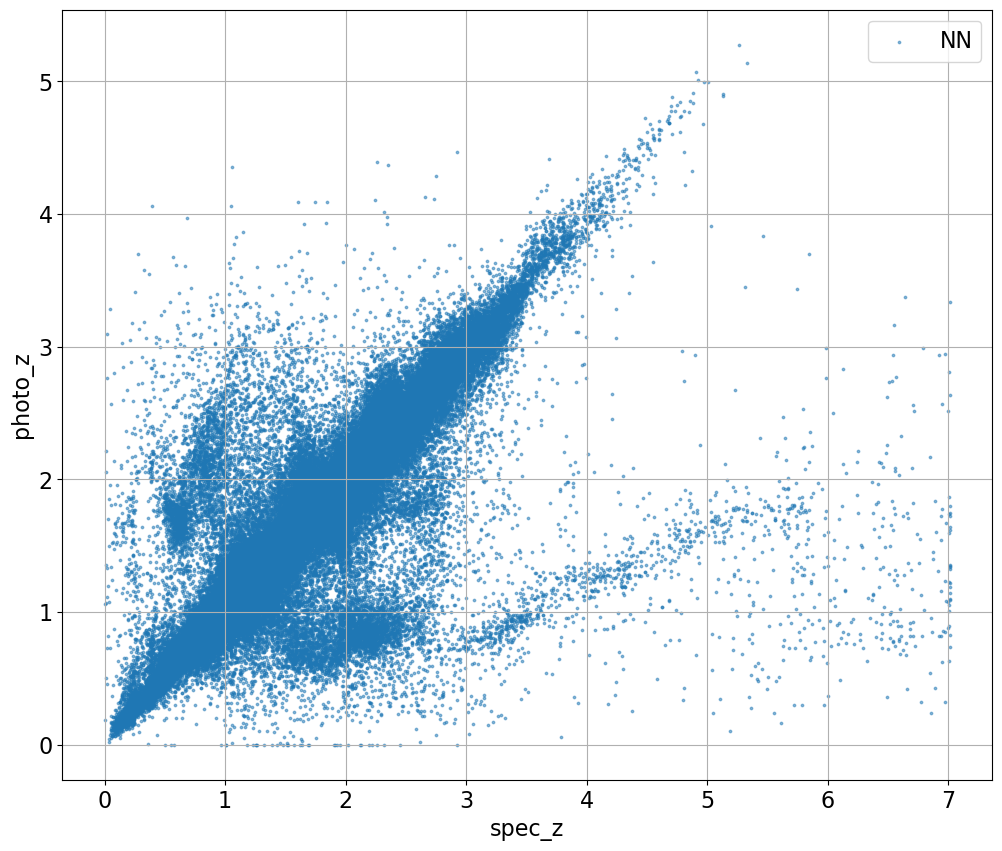

In [27]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.grid()

plt.scatter(dr16q['Z'][(dr16q['Z'] > 0) & ~m], dr16q['mode'][(dr16q['Z'] > 0) & ~m], alpha=0.5, s=3, label='NN')
plt.legend()
plt.xlabel('spec_z')
plt.ylabel('photo_z')
pass;

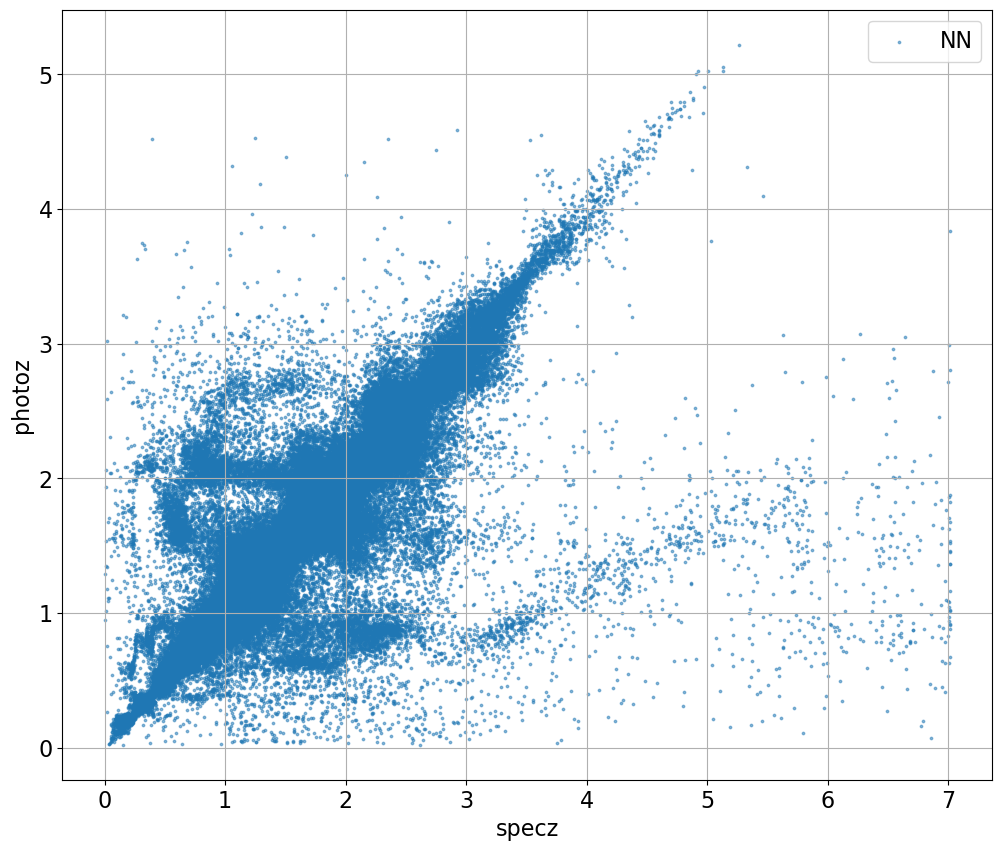

In [28]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.grid()

plt.scatter(dr16q['Z'][(dr16q['Z'] > 0) & ~m], dr16q['max35_z'][(dr16q['Z'] > 0) & ~m], alpha=0.5, s=3, label='NN')
plt.legend()
plt.xlabel('specz')
plt.ylabel('photoz')
pass;

In [29]:
c = correlate(dr16q_prop[['RA', 'DEC']].values, dr16q[['RA', 'DEC']].values)
np.unique(c[:,0].astype(int)).shape

100%|██████████| 306740/306740 [00:43<00:00, 7133.38it/s]


(306740,)

In [30]:
print(c[:,0].astype(int))
print(c[:, 1].max())
np.unique(c[:,0].astype(int)).shape

[     1      2      3 ... 750402 750403 750404]
2.0913097891518726e-06


(306740,)

In [31]:
full_01 = dr16q_prop.copy()
full_01.loc[c[:, 0].astype(int), features_list + models_cols] = dr16q[features_list + models_cols].values
full_01

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,b'7750-58402-0802',0.000629,35.517841,0.845435,0.846867,0.000704,0.001432,0.001432,True,False,...,None,None,None,None,None,None,None,None,None,None
1,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.2842,0.631614,0.399665,0.230327,0.500169,0.814194,0.200983,0.301492,0.319025,2.095915
2,b'7695-57654-0565',0.001526,27.732283,1.770552,1.774080,0.002622,0.003528,0.003528,True,False,...,0.11679,0.435134,0.52713,0.086485,1.052853,0.098946,0.441917,0.828959,0.089006,1.611841
3,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.296987,0.76791,0.103907,0.497488,0.682497,0.523818,0.288939,0.222688,0.217595,1.575937
4,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750409,b'7134-56566-0408',359.999118,28.954734,2.452000,2.451400,0.005250,-0.000600,0.000600,True,False,...,None,None,None,None,None,None,None,None,None,None
750410,b'7145-56567-0240',359.999303,34.720842,3.109000,3.112038,0.006417,0.003038,0.003038,True,False,...,None,None,None,None,None,None,None,None,None,None
750411,b'8741-57390-0060',359.999615,3.268586,1.232962,1.233783,0.000758,0.000821,0.000821,True,False,...,None,None,None,None,None,None,None,None,None,None
750412,b'7595-56957-0259',359.999759,20.721079,2.009865,2.013729,0.002790,0.003864,0.003864,True,False,...,None,None,None,None,None,None,None,None,None,None


In [32]:
(~full_01['max22_z'].isna()).sum()

304815

In [33]:
dfs = []

feas = pd.read_pickle(
    f'{data_dir}/20_2-fold-cv/cv2_0/part-00000.features.gz_pkl',
    compression='gzip'
)[['ra', 'dec', 'zspec'] + features_list]
preds = pd.read_pickle(
    f'{data_dir}/20_2-fold-cv/cv2_0/part-00000.predictions.x1cv2_0.gz_pkl',
    compression='gzip'
)[[
    'zoo_x1cv2_019_z_max', 'zoo_x1cv2_019_z_maxConf',
    'zoo_x1cv2_021_z_max', 'zoo_x1cv2_021_z_maxConf',
    'zoo_x1cv2_022_z_max', 'zoo_x1cv2_022_z_maxConf',
    'zoo_x1cv2_035_z_max', 'zoo_x1cv2_035_z_maxConf'
]]
df = feas.merge(preds, how='right', left_index=True, right_index=True)
df.sort_values(by=['ra'], inplace=True)

m = (df.isna().values.sum(1) > 0)
X = df[features_list].values[~m].astype(float)
epoch_pi_00_35, epoch_mu_00_35, epoch_sigma_00_35, mode_00_35, sigma_00_35 = ens_01_35.predict(X)
for s in ['pi', 'mu', 'sigma']:
    for i in range(15):
        df[f'{s}_{str(i).zfill(2)}_35'] = [None] * df.shape[0]
        if s == 'pi':
            df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_pi_00_35[:, i].copy()
        if s == 'mu':
            df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_mu_00_35[:, i].copy()
        if s == 'sigma':
            df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_sigma_00_35[:, i].copy()
df['sigma'] = [None] * df.shape[0]
df['sigma'][~m] = sigma_00_35.copy()
df['mode'] = [None] * df.shape[0]
df['mode'][~m] = mode_00_35.copy()

df.columns = dr16q.columns.copy()
dfs.append(df)

feas = pd.read_pickle(
    f'{data_dir}/20_2-fold-cv/cv2_1/part-00000.features.gz_pkl',
    compression='gzip'
)[['ra', 'dec', 'zspec'] + features_list]
preds = pd.read_pickle(
    f'{data_dir}/20_2-fold-cv/cv2_1/part-00000.predictions.x1cv2_1.gz_pkl',
    compression='gzip'
)[[
    'zoo_x1cv2_119_z_max', 'zoo_x1cv2_119_z_maxConf',
    'zoo_x1cv2_121_z_max', 'zoo_x1cv2_121_z_maxConf',
    'zoo_x1cv2_122_z_max', 'zoo_x1cv2_122_z_maxConf',
    'zoo_x1cv2_135_z_max', 'zoo_x1cv2_135_z_maxConf'
]]
df = feas.merge(preds, how='right', left_index=True, right_index=True)
df.sort_values(by=['ra'], inplace=True)

m = (df.isna().values.sum(1) > 0)
X = df[features_list].values[~m].astype(float)
epoch_pi_01_35, epoch_mu_01_35, epoch_sigma_01_35, mode_01_35, sigma_01_35 = ens_00_35.predict(X)
for s in ['pi', 'mu', 'sigma']:
    for i in range(15):
        df[f'{s}_{str(i).zfill(2)}_35'] = [None] * df.shape[0]
        if s == 'pi':
            df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_pi_01_35[:, i].copy()
        if s == 'mu':
            df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_mu_01_35[:, i].copy()
        if s == 'sigma':
            df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_sigma_01_35[:, i].copy()
df['sigma'] = [None] * df.shape[0]
df['sigma'][~m] = sigma_01_35.copy()
df['mode'] = [None] * df.shape[0]
df['mode'][~m] = mode_01_35.copy()

df.columns = dr16q.columns.copy()
dfs.append(df)

train_20 = pd.concat(dfs, axis=0)
train_20.sort_values(by=['RA'], inplace=True)
train_20.drop_duplicates(subset=['RA', 'DEC'], inplace=True, keep='last')
train_20.reset_index(drop=True, inplace=True)
train_20.replace(np.nan, None, inplace=True)
train_20

/tmp/ipykernel_2036690/3456364373.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_pi_00_35[:, i].copy()
/tmp/ipykernel_2036690/3456364373.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_pi_00_35[:, i].copy()
/tmp/ipykernel_2036690/3456364373.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{s}_{str(i).zfill(2)}_35'][~m] = epoch_pi

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,0.000722,11.343983,0.442757,23.3769,22.425905,20.79993,20.031074,19.62268,20.226514,19.305746,...,0.911895,0.066808,0.032184,0.783755,0.050213,0.625028,0.027926,0.047725,0.029942,0.471513
1,0.001417,18.492306,0.629820,22.113601,22.968215,21.524378,20.363373,19.827644,22.126405,19.405817,...,0.954108,0.071092,0.027673,0.678002,0.061433,0.739527,0.030936,0.049158,0.030542,0.633138
2,0.001885,17.773712,2.309000,22.265783,21.813904,21.999912,21.87019,21.266889,22.34359,21.853381,...,0.249003,1.057374,0.414208,0.194438,0.164616,0.17621,0.335601,0.490732,0.161861,2.20362
3,0.002416,5.941882,2.103120,22.059562,21.434419,21.211019,21.184635,20.688257,22.046778,21.198729,...,0.063118,0.071936,0.058657,0.268568,0.222473,0.503271,0.064117,0.24347,0.788925,0.760818
4,0.002769,14.974691,2.497000,21.761608,21.095956,20.797531,20.715893,20.589152,21.633194,20.676625,...,0.146385,0.672847,0.403496,0.140304,0.743286,1.075822,0.181831,0.12322,0.139387,2.482719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580451,359.998949,10.116818,2.415000,23.056658,21.692741,21.373058,21.15195,21.260001,21.525019,21.153138,...,0.262728,0.851933,0.201769,0.214182,0.616996,0.585482,0.148855,0.27174,0.70463,2.739029
580452,359.999026,24.413551,1.490065,20.921111,20.732991,20.529058,20.355686,20.119849,20.765828,20.362367,...,0.241674,0.540159,0.175822,0.395499,0.354688,0.706257,0.295579,0.172097,0.205009,1.397659
580453,359.999121,28.954727,2.452000,21.876842,21.168578,21.233727,21.235761,20.713764,21.639407,21.276328,...,0.180499,0.796216,0.343325,0.106288,0.100276,0.072891,0.364991,0.25875,0.084871,2.424912
580454,359.999634,3.268618,1.233161,18.791953,18.815835,18.557703,18.614296,18.673656,18.798606,18.611784,...,0.30394,0.073077,0.058461,1.340983,0.141165,1.094194,0.058255,0.069625,0.060528,1.227826


In [34]:
X

array([[22.26578296, 21.81390357, 21.99991227, ...,  0.38443933,
         0.45045578, -0.28709846],
       [22.05956235, 21.43441895, 21.21101889, ..., -0.14491664,
        -0.26569414, -0.54398046],
       [20.29384849, 19.83694082, 19.55035015, ..., -0.15878492,
        -0.13623325, -0.16927165],
       ...,
       [21.31474047, 20.8127185 , 20.67042454, ..., -0.2014316 ,
        -0.28009113, -0.78420079],
       [19.82941833, 19.81545524, 19.55178993, ..., -0.56484717,
        -0.42786027, -0.53959166],
       [21.87684207, 21.16857839, 21.23372662, ...,  0.08148479,
         0.03779553, -0.51335304]])

In [35]:
m = (train_20.isna().values.sum(1) > 0)

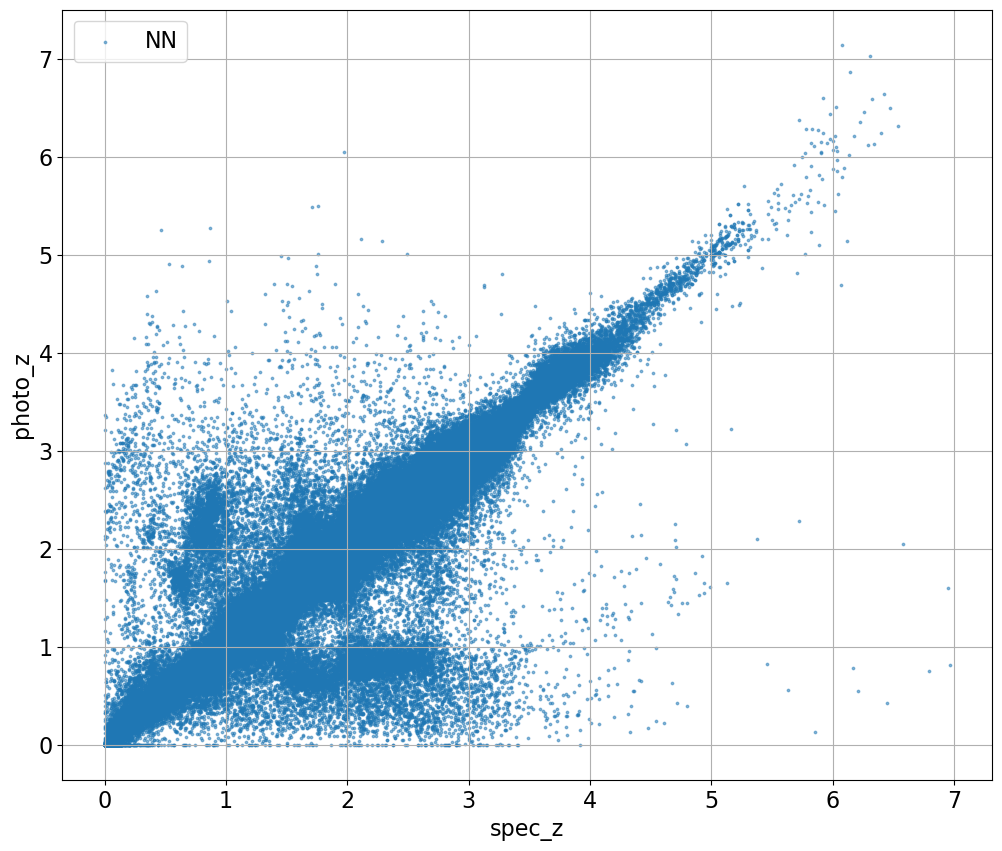

In [36]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.grid()

plt.scatter(train_20['Z'][(train_20['Z'] > 0) & ~m], train_20['mode'][(train_20['Z'] > 0) & ~m], alpha=0.5, s=3, label='NN')
plt.legend()
plt.xlabel('spec_z')
plt.ylabel('photo_z')
pass;

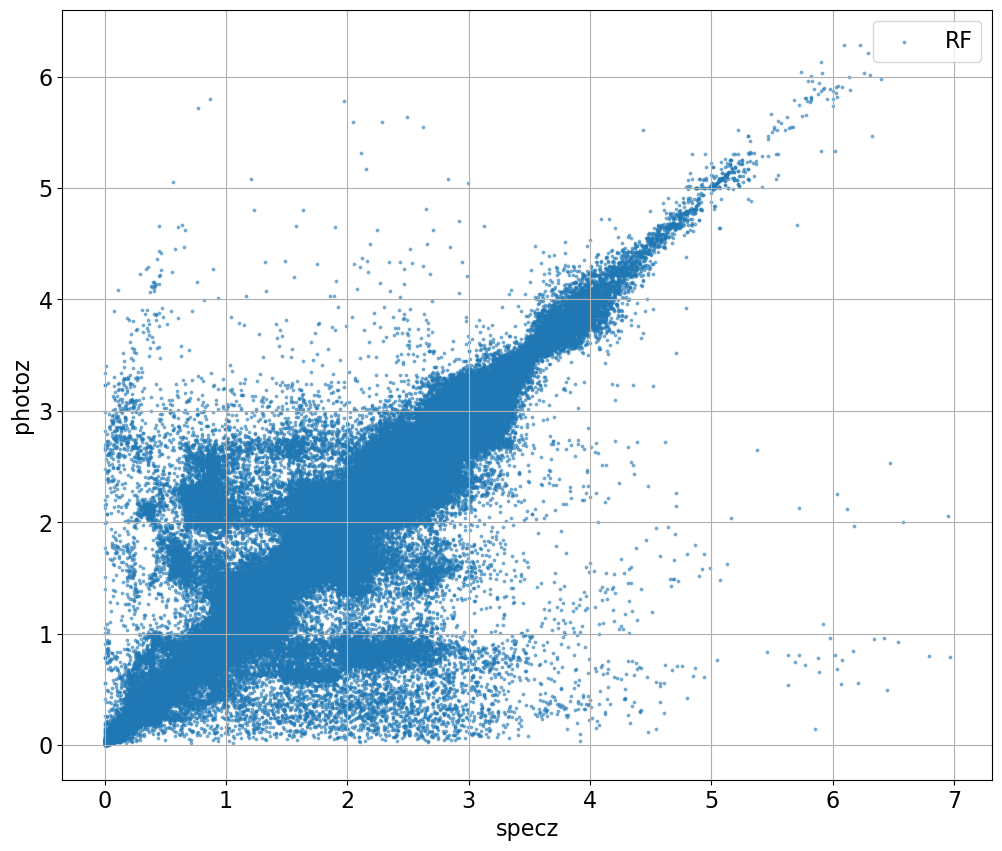

In [37]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.grid()

plt.scatter(train_20['Z'][(train_20['Z'] > 0) & ~m], train_20['max35_z'][(train_20['Z'] > 0) & ~m], alpha=0.5, s=3, label='RF')
plt.legend()
plt.xlabel('specz')
plt.ylabel('photoz')
pass;

In [41]:
out_rate_z5(train_20['Z'][~m], train_20['mode'][~m])

0.05755395683453238

In [40]:
out_rate_z5(train_20['Z'][~m], train_20['max35_z'][~m])

0.12949640287769784

In [42]:
c = correlate(dr16q_prop[['RA', 'DEC']].values, train_20[['RA', 'DEC']].values)
np.unique(c[:,0].astype(int)).shape

100%|██████████| 580456/580456 [01:19<00:00, 7276.62it/s]


(469499,)

In [43]:
(c[:,1] <= 1/3600).sum(), np.unique(c[c[:,1] <= 1/3600,0].astype(int)).shape

(437833, (437473,))

In [44]:
full_02 = full_01.copy()
full_02.loc[c[c[:,1] <= 1/3600, 0].astype(int), features_list + models_cols] = train_20.loc[c[c[:,1] <= 1/3600, 2].astype(int), features_list + models_cols].values
full_02.loc[c[c[:,1] <= 1/3600, 0].astype(int), 'train20'] = True
full_02

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,b'7750-58402-0802',0.000629,35.517841,0.845435,0.846867,0.000704,0.001432,0.001432,True,False,...,None,None,None,None,None,None,None,None,None,None
1,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.2842,0.631614,0.399665,0.230327,0.500169,0.814194,0.200983,0.301492,0.319025,2.095915
2,b'7695-57654-0565',0.001526,27.732283,1.770552,1.774080,0.002622,0.003528,0.003528,True,False,...,0.11679,0.435134,0.52713,0.086485,1.052853,0.098946,0.441917,0.828959,0.089006,1.611841
3,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.296987,0.76791,0.103907,0.497488,0.682497,0.523818,0.288939,0.222688,0.217595,1.575937
4,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.249003,1.057374,0.414208,0.194438,0.164616,0.17621,0.335601,0.490732,0.161861,2.20362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750409,b'7134-56566-0408',359.999118,28.954734,2.452000,2.451400,0.005250,-0.000600,0.000600,True,False,...,0.180499,0.796216,0.343325,0.106288,0.100276,0.072891,0.364991,0.25875,0.084871,2.424912
750410,b'7145-56567-0240',359.999303,34.720842,3.109000,3.112038,0.006417,0.003038,0.003038,True,False,...,None,None,None,None,None,None,None,None,None,None
750411,b'8741-57390-0060',359.999615,3.268586,1.232962,1.233783,0.000758,0.000821,0.000821,True,False,...,0.30394,0.073077,0.058461,1.340983,0.141165,1.094194,0.058255,0.069625,0.060528,1.227826
750412,b'7595-56957-0259',359.999759,20.721079,2.009865,2.013729,0.002790,0.003864,0.003864,True,False,...,0.063239,0.299434,0.148,0.044022,0.748869,1.229483,0.326818,0.066211,0.06003,1.984419


In [46]:
train_20_out = train_20[c[:,1] > 1/3600]
train_20_out.reset_index(drop=True, inplace=True)
train_20_out.insert(0, 'OBJID', None)
train_20_out.insert(4, 'Z_SYS', None)
train_20_out.insert(5, 'Z_SYS_ERR', None)
train_20_out.insert(6, 'Z_SYS_DIFF', None)
train_20_out.insert(7, 'Z_SYS_DIFF_ABS', None)
train_20_out.insert(8, 'dr16q', False)
train_20_out.insert(9, 'dr16q_prop', False)
train_20_out.insert(10, 'train20', True)
train_20_out.insert(11, 'superset', False)
train_20_out

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,None,0.000722,11.343983,0.442757,None,None,None,None,False,False,...,0.911895,0.066808,0.032184,0.783755,0.050213,0.625028,0.027926,0.047725,0.029942,0.471513
1,None,0.001417,18.492306,0.629820,None,None,None,None,False,False,...,0.954108,0.071092,0.027673,0.678002,0.061433,0.739527,0.030936,0.049158,0.030542,0.633138
2,None,0.003054,22.654332,0.687130,None,None,None,None,False,False,...,0.927978,0.074974,0.024253,0.947405,0.051819,0.695859,0.024725,0.036596,0.027784,0.667676
3,None,0.004471,-2.661104,0.459787,None,None,None,None,False,False,...,0.03252,0.803287,0.026103,1.32332,0.027366,0.483739,0.028851,0.264708,0.031889,0.420093
4,None,0.007367,19.547288,0.090489,None,None,None,None,False,False,...,0.87274,0.108746,0.027912,0.733421,0.030909,0.725291,0.026586,0.036456,0.030309,0.157659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142618,None,359.989649,17.861844,1.146000,None,None,None,None,False,False,...,0.119657,0.176916,0.238701,0.14665,0.889243,0.126902,0.234768,0.779276,0.12962,1.257039
142619,None,359.989956,5.066145,0.334862,None,None,None,None,False,False,...,5.95978,0.548624,0.436451,0.753389,2.211479,0.843704,0.429626,3.129062,0.813887,1.891448
142620,None,359.992068,18.476645,1.283000,None,None,None,None,False,False,...,0.080116,0.100047,0.172493,0.088506,2.330624,0.093557,0.172659,1.232371,0.090907,1.251834
142621,None,359.994125,3.739318,0.483395,None,None,None,None,False,False,...,0.030497,0.808937,0.028717,1.235162,0.02853,0.377948,0.02758,0.229883,0.031772,0.493921


In [47]:
full_03 = pd.concat((full_02, train_20_out), axis=0)
full_03.reset_index(drop=True, inplace=True)
full_03.replace(np.nan, None, inplace=True)
full_03

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,b'7750-58402-0802',0.000629,35.517841,0.845435,0.846867,0.000704,0.001432,0.001432,True,False,...,None,None,None,None,None,None,None,None,None,None
1,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.2842,0.631614,0.399665,0.230327,0.500169,0.814194,0.200983,0.301492,0.319025,2.095915
2,b'7695-57654-0565',0.001526,27.732283,1.770552,1.77408,0.002622,0.003528,0.003528,True,False,...,0.11679,0.435134,0.52713,0.086485,1.052853,0.098946,0.441917,0.828959,0.089006,1.611841
3,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.296987,0.76791,0.103907,0.497488,0.682497,0.523818,0.288939,0.222688,0.217595,1.575937
4,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.249003,1.057374,0.414208,0.194438,0.164616,0.17621,0.335601,0.490732,0.161861,2.20362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893032,None,359.989649,17.861844,1.146000,None,None,None,None,False,False,...,0.119657,0.176916,0.238701,0.14665,0.889243,0.126902,0.234768,0.779276,0.12962,1.257039
893033,None,359.989956,5.066145,0.334862,None,None,None,None,False,False,...,5.95978,0.548624,0.436451,0.753389,2.211479,0.843704,0.429626,3.129062,0.813887,1.891448
893034,None,359.992068,18.476645,1.283000,None,None,None,None,False,False,...,0.080116,0.100047,0.172493,0.088506,2.330624,0.093557,0.172659,1.232371,0.090907,1.251834
893035,None,359.994125,3.739318,0.483395,None,None,None,None,False,False,...,0.030497,0.808937,0.028717,1.235162,0.02853,0.377948,0.02758,0.229883,0.031772,0.493921


In [53]:
superset = pd.read_csv(f'{data_dir}/proc_superset.csv')
superset.drop(columns='SOURCE', inplace=True)
superset.reset_index(drop=True, inplace=True)
superset.insert(0, 'OBJID', None)
superset.insert(4, 'Z_SYS', None)
superset.insert(5, 'Z_SYS_ERR', None)
superset.insert(6, 'Z_SYS_DIFF', None)
superset.insert(7, 'Z_SYS_DIFF_ABS', None)
superset.insert(8, 'dr16q', False)
superset.insert(9, 'dr16q_prop', False)
superset.insert(10, 'train20', False)
superset.insert(11, 'superset', True)
superset.insert(77, 'max19_z', None)
superset.insert(78, 'conf19_z', None)
superset.insert(79, 'max21_z', None)
superset.insert(80, 'conf21_z', None)
superset.insert(81, 'max22_z', None)
superset.insert(82, 'conf22_z', None)
superset.rename(
    columns={
        'zoo_x1a35_z_max': 'max35_z', 'zoo_x1a35_z_maxConf': 'conf35_z'
    }, inplace=True)
X = superset[features_list].values.astype(float)
epoch_pi_00_35, epoch_mu_00_35, epoch_sigma_00_35, mode_00_35, sigma_00_35 = ens_00_35.predict(X)
epoch_pi_01_35, epoch_mu_01_35, epoch_sigma_01_35, mode_01_35, sigma_01_35 = ens_01_35.predict(X)
m_s = (sigma_00_35 <= sigma_01_35)
epoch_pi_00_35[~m_s] = epoch_pi_01_35[~m_s]
epoch_mu_00_35[~m_s] = epoch_mu_01_35[~m_s]
epoch_sigma_00_35[~m_s] = epoch_sigma_01_35[~m_s]
mode_00_35[~m_s] = mode_01_35[~m_s]
sigma_00_35[~m_s] = sigma_01_35[~m_s]
for s in ['pi', 'mu', 'sigma']:
    for i in range(15):
        superset[f'{s}_{str(i).zfill(2)}_35'] = [None] * superset.shape[0]
        if s == 'pi':
            superset[f'{s}_{str(i).zfill(2)}_35'] = epoch_pi_00_35[:, i].copy()
        if s == 'mu':
            superset[f'{s}_{str(i).zfill(2)}_35'] = epoch_mu_00_35[:, i].copy()
        if s == 'sigma':
            superset[f'{s}_{str(i).zfill(2)}_35'] = epoch_sigma_00_35[:, i].copy()
superset['sigma'] = [None] * superset.shape[0]
superset['sigma'] = sigma_00_35.copy()
superset['mode'] = [None] * superset.shape[0]
superset['mode'] = mode_00_35.copy()
superset

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,None,138.718517,56.280226,-1.000000,None,None,None,None,False,False,...,0.103248,0.354925,0.085360,0.327421,0.247135,0.508051,0.179845,1.176046,0.295544,0.639799
1,None,119.299997,22.527369,-0.011447,None,None,None,None,False,False,...,0.410262,0.428569,0.286092,0.364973,0.155970,0.276417,0.291609,0.169702,0.417372,3.165899
2,None,262.134784,36.734522,-0.011332,None,None,None,None,False,False,...,18.801517,1.210850,0.403381,1.011350,0.536854,0.495625,0.235876,0.260779,0.873871,3.853072
3,None,327.439561,-0.195568,-0.011123,None,None,None,None,False,False,...,1.679690,0.815024,0.598520,0.379788,0.379007,1.134066,0.167027,0.327934,1.584630,0.360759
4,None,217.129032,15.540025,-0.010959,None,None,None,None,False,False,...,10.354478,1.111096,0.682077,1.009042,0.918186,0.681640,0.261894,0.414532,1.484779,3.052652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365341,None,201.934129,12.271040,7.021599,None,None,None,None,False,False,...,23.431009,0.384996,3.306514,0.686861,0.579473,0.365884,0.170109,0.390067,0.671535,2.789820
365342,None,36.002095,-0.394057,7.027864,None,None,None,None,False,False,...,0.170544,0.287176,0.102943,0.142040,0.206266,0.186966,0.111225,0.436360,0.374554,1.815811
365343,None,179.515381,45.946690,7.029899,None,None,None,None,False,False,...,0.044090,0.868317,0.053157,0.876939,0.121065,0.378635,0.033186,0.656538,0.075233,0.725941
365344,None,0.306355,6.436817,7.030458,None,None,None,None,False,False,...,0.180951,0.561728,0.162267,0.783864,0.639419,0.813738,0.157822,0.607947,0.366948,0.528063


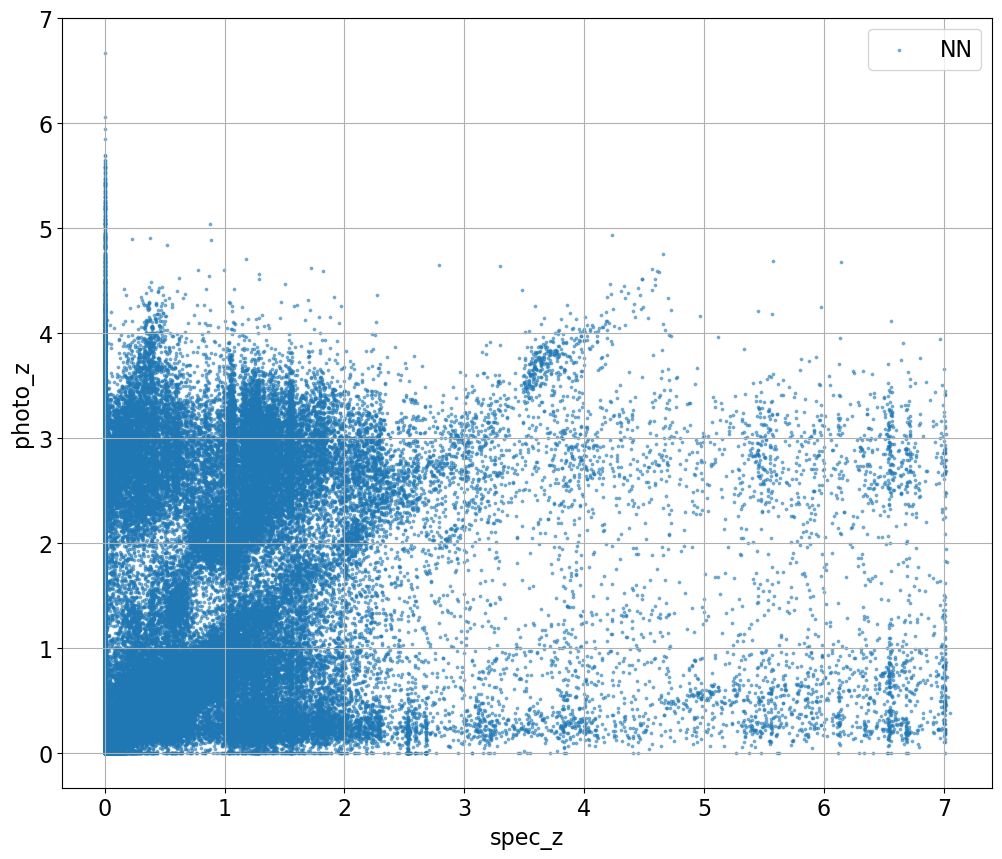

In [54]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.grid()

plt.scatter(superset['Z'][(superset['Z'] > 0)], superset['mode'][(superset['Z'] > 0)], alpha=0.5, s=3, label='NN')
plt.legend()
plt.xlabel('spec_z')
plt.ylabel('photo_z')
pass;

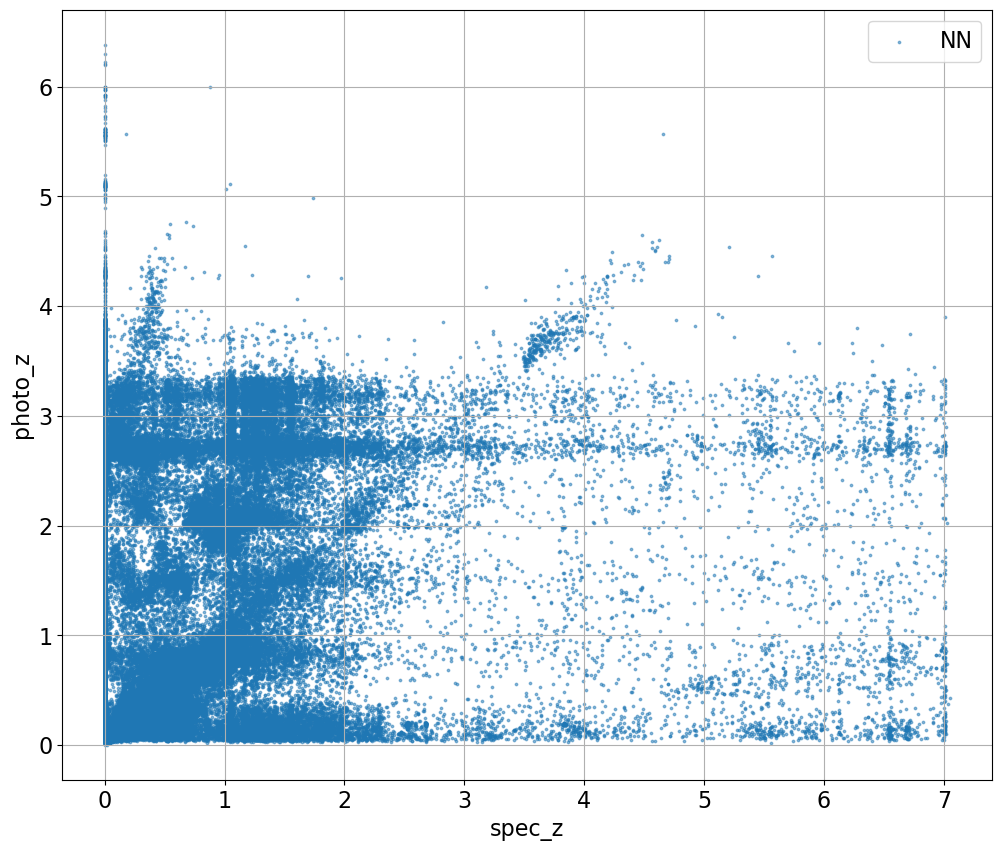

In [57]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.grid()

plt.scatter(superset['Z'][(superset['Z'] > 0)], superset['max35_z'][(superset['Z'] > 0)], alpha=0.5, s=3, label='NN')
plt.legend()
plt.xlabel('spec_z')
plt.ylabel('photo_z')
pass;

In [58]:
full_04 = pd.concat((full_03, superset), axis=0)
full_04.reset_index(drop=True, inplace=True)
full_04.replace(np.nan, None, inplace=True)
full_04

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
0,b'7750-58402-0802',0.000629,35.517841,0.845435,0.846867,0.000704,0.001432,0.001432,True,False,...,None,None,None,None,None,None,None,None,None,None
1,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.2842,0.631614,0.399665,0.230327,0.500169,0.814194,0.200983,0.301492,0.319025,2.095915
2,b'7695-57654-0565',0.001526,27.732283,1.770552,1.77408,0.002622,0.003528,0.003528,True,False,...,0.11679,0.435134,0.52713,0.086485,1.052853,0.098946,0.441917,0.828959,0.089006,1.611841
3,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.296987,0.76791,0.103907,0.497488,0.682497,0.523818,0.288939,0.222688,0.217595,1.575937
4,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.249003,1.057374,0.414208,0.194438,0.164616,0.17621,0.335601,0.490732,0.161861,2.20362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258378,None,201.934129,12.271040,7.021599,None,None,None,None,False,False,...,23.431009,0.384996,3.306514,0.686861,0.579473,0.365884,0.170109,0.390067,0.671535,2.78982
1258379,None,36.002095,-0.394057,7.027864,None,None,None,None,False,False,...,0.170544,0.287176,0.102943,0.14204,0.206266,0.186966,0.111225,0.43636,0.374554,1.815811
1258380,None,179.515381,45.946690,7.029899,None,None,None,None,False,False,...,0.04409,0.868317,0.053157,0.876939,0.121065,0.378635,0.033186,0.656538,0.075233,0.725941
1258381,None,0.306355,6.436817,7.030458,None,None,None,None,False,False,...,0.180951,0.561728,0.162267,0.783864,0.639419,0.813738,0.157822,0.607947,0.366948,0.528063


In [59]:
full_04.to_csv(f'{data_dir}/full_dr16q_train20_superset.csv', index=False)

In [60]:
full_04[(full_04['train20']) & (full_04['dr16q_prop'])]

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
714,b'7666-57339-0127',0.182396,24.708938,2.812042,2.055525,0.002691,-0.756517,0.756517,True,True,...,0.0404,0.45734,0.048454,0.05136,1.247433,1.46548,0.225657,0.044644,0.052853,2.147255
5570,b'8740-57367-0008',1.489409,5.237260,4.804017,1.532229,0.001289,-3.271787,3.271787,True,True,...,0.581439,0.584661,0.255502,0.61671,0.336214,0.41197,0.34056,0.314039,0.837565,1.449255
12522,b'6279-56243-0538',3.435045,24.955056,2.405000,1.676462,0.003814,-0.728538,0.728538,True,True,...,0.136383,0.701243,0.22648,0.164549,0.762733,0.494595,0.461126,0.198217,0.199139,2.051081
12695,b'7169-56628-0800',3.488202,-8.559648,4.193000,1.265264,0.000869,-2.927736,2.927736,True,True,...,0.129196,0.131949,0.272753,0.120282,2.292287,0.065665,0.496557,1.858287,0.104378,1.197347
13690,b'6184-56267-0488',3.794226,13.819518,3.215000,0.851655,0.001316,-2.363345,2.363345,True,True,...,0.065717,0.078384,0.088488,0.055335,1.000911,0.060995,0.057504,0.799268,0.085076,0.86273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729559,b'6137-56270-0272',353.604729,15.931345,3.314000,2.413811,0.002817,-0.900189,0.900189,True,True,...,0.145916,0.824814,0.206616,0.165084,0.814105,0.731948,0.151035,0.142158,0.176843,2.635178
740156,b'7599-56955-0230',357.162398,17.801085,0.199574,0.573994,0.000317,0.37442,0.37442,True,True,...,0.905389,0.300014,0.187458,0.546665,0.372504,0.553613,0.149815,0.640237,0.392414,0.660987
741105,b'8742-57364-0601',357.461297,6.252755,6.949000,1.533203,0.002761,-5.415797,5.415797,True,True,...,0.265418,0.593851,0.258731,0.340067,0.557147,0.393799,0.50929,0.158464,0.338193,1.595259
741550,b'7851-56932-0656',357.587732,-1.735379,5.299385,1.761067,0.002688,-3.538318,3.538318,True,True,...,0.397968,0.702646,0.18459,0.553473,0.32173,0.381235,0.305643,0.260336,0.785753,0.606883


In [61]:
full_04[full_04['Z'] <= -1]

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_07_35,sigma_08_35,sigma_09_35,sigma_10_35,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode
164256,b'4501-55590-0178',120.312580,13.611725,-999.0,0.0,-1.0,999.0,999.0,True,True,...,None,None,None,None,None,None,None,None,None,None
336175,b'5356-55979-0876',164.698568,11.187737,-999.0,0.4,-1.0,999.4,999.4,True,True,...,0.390028,0.083086,0.082859,0.296347,0.1054,0.606478,0.083901,0.398665,0.179227,0.531943
469936,b'8201-58146-0270',201.119434,57.278030,-999.0,1.077868,0.010941,1000.077868,1000.077868,True,True,...,None,None,None,None,None,None,None,None,None,None
628132,b'4190-55686-0354',249.214456,26.449127,-999.0,0.8,-1.0,999.8,999.8,True,True,...,0.536093,0.131115,0.066378,0.472369,0.062784,0.72896,0.109238,0.504625,0.191888,0.690168
893037,None,138.718517,56.280226,-1.0,None,None,None,None,False,False,...,0.103248,0.354925,0.08536,0.327421,0.247135,0.508051,0.179845,1.176046,0.295544,0.639799
